# Urban Heat Island (UHI) Benchmark Notebook

### Approach
This approach takes inspiration from the sample notebook provided by the organizers: **UHI Experiment Sample Benchmark Notebook V5.ipynb**.

**Steps:**
1. **Generate a TIFF image** capturing multispectral bands over New York for the targeted date: **July 24, 2021**.
2. **Compute indices** from the bands, including:
   - Normalized Difference Vegetation Index (**NDVI**)
   - Normalized Difference Built-up Index (**NDBI**)
   - Enhanced Vegetation Index (**EVI**)
   - Normalized Difference Water Index (**NDWI**)
   - Fractional Vegetation Cover (**FVC**)
   - Emissivity (**E**)
3. **Apply spatial convolution** on **NDVI** and **NDBI** indices to enhance spatial feature extraction.
4. **Train a model using AutoGluon**:
   - **Configuration:** `best_quality` training mode
   - **Training time limit:** `3600` seconds (1 hour)

**Experiment Results**
Through multiple index combinations, we observed the following performance:
- Using bands **'B01', 'B06', 'B11', 'NDVI', 'NDWI'**, we achieved an **R² score of 0.83**.
- By adding **NDVI_convoluted** and **NDWI_convoluted** to the above features, the **R² score improved to 0.8345**.

## Challenge Overview

<p align="justify">Welcome to the EY Open Science AI & Data Challenge 2025! The objective of this challenge is to build a machine learning model to predict urban heat island (UHI) hotspots in a city. By the end of the challenge, you will have developed a regression model capable of predicting the intensity of the UHI effect.

Participants will be given ground-level air temperature data in an index format, which was collected on 24th July 2021 on traverse points in the Bronx and Manhattan regions of New York city. This dataset constitutes traverse points (latitude and longitude) and their corresponding UHI (Urban Heat Island) index values. Participants will use this dataset to build a regression model to predict UHI index values for a given set of locations. It is important to understand that the UHI Index at any given location is indicative of the relative temperature elevation at that specific point compared to the city's average temperature.

This challenge is designed for participants with varying skill levels in data science and programming, offering a great opportunity to apply your knowledge and enhance your capabilities in the field.</p>

<b>Challenge Aim: </b><p align="justify"> <p>

<p align="justify">In this notebook, we will demonstrate a basic model workflow that can serve as a starting point for the challenge. The basic model has been constructed to predict the Urban Heat Island (UHI) index using features from the Sentinel-2 satellite dataset as predictor variables. In this demonstration, we utilized three features from the Sentinel-2 dataset: band B01 (Coastal Aerosol), band B06 (Red Edge), and NDVI (Normalized Difference Vegetation Index) derived from bands B04 (Red) and B08 (Near Infrared). A random forest regression model was then trained using these features.
    
These features were extracted from a GeoTIFF image created by the Sentinel-2 sample notebook. For the sample model shown in this notebook, data from a single day (24th July 2021) was considered, assuming that the values of bands B01, B04, B06, and B08 for this specific date are representative of the UHI index behavior at any location. Participants should review the details of the Sentinel-2 sample notebook to gain an understanding of the data and options for modifying the output product.
    
</p>

<p align="justify">Most of the functions presented in this notebook were adapted from the <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook">Sentinel-2-Level-2A notebook</a> found in the Planetary Computer portal.</p>

<p align="justify">Please note that this notebook is just a starting point. We have made many assumptions in this notebook that you may think are not best for solving the challenge effectively. You are encouraged to modify these functions, rewrite them, or try an entirely new approach.</p>


## Dependencies loading

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take some time.  

In [3]:
!pip install rioxarray
!pip install rasterio
!python -m pip install pystac-client
!pip install planetary-computer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 11.8 MB/s eta 0:00:00


In [4]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
from rasterio.warp import transform_bounds
from rasterio.windows import from_bounds

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
import os
from tqdm import tqdm



## Data loading and processing

### Response Variable

Before building the model, we need to load in the Urban Heat Island (UHI) index training dataset. We have curated data for the New York region. The dataset consists of geo-locations (Longitude and Latitude), with additional fields including date & time of data collection and the UHI index for each location.

In [5]:
# Load the training data from csv file and display the first few rows to inspect the data
ground_df = pd.read_csv("Training_data_uhi_index_UHI2025-v2.csv")
ground_df.head()

,Longitude,Latitude,datetime,UHI Index
0,-73.909167,40.813107,24-07-2021 15:53,1.030289
1,-73.909187,40.813045,24-07-2021 15:53,1.030289
2,-73.909215,40.812978,24-07-2021 15:53,1.023798
3,-73.909242,40.812908,24-07-2021 15:53,1.023798
4,-73.909257,40.812845,24-07-2021 15:53,1.021634


### Predictor Variables

<p align="justify">Now that we have our UHI data, it is time to gather the predictor variables from the Sentinel-2 dataset. Participants should review the provided Sentinel-2 sample notebook as it was used to create a sample GeoTIFF for this models. For a more in-depth look regarding the Sentinel-2 dataset and how to query it, see the Microsoft Planetary Computer example <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook">Sentinel-2 supplementary notebook</a>. </p>

<p align="justify">Sentinel-2 optical data provides high-resolution imagery that is sensitive to land surface characteristics, which are crucial for understanding urban heat dynamics. Band values such as B01 (Coastal aerosol), B06 (Red Edge), and NDVI (Normalized Difference Vegetation Index) derived from B04 (Red) and B08 (Near Infrared) help us in estimating the UHI index. Hence, we are choosing B01, B06, and NDVI as predictor variables for this experiment.</p>

<ul>
<li>B01 - Reflectance values from the Coastal aerosol band, which help in assessing aerosol presence and improving atmospheric correction.</li>

<li>B06 - Reflectance values from the Red Edge band, which provide useful information for detecting vegetation, water bodies, and urban surfaces.</li>

<li>NDVI - Derived from B04 (Red) and B08 (Near Infrared), NDVI is an important indicator for vegetation health and land cover.</li>
</ul>


<h4><strong>Tip 1</strong></h4>
<p align="justify">Participants might explore other combinations of bands from the Sentinel-2 and from other satellite datasets as well. For example, you can use mathematical combinations of bands to generate various indices </a> which can then be used as features in your model. These bands or indices may provide insights into surface characteristics, vegetation, or built-up areas that could influence UHI patterns.

### Analyze the Sentinel-2 Data

<p align="justify">To obtain the Sentinel-2 data, we created a GeoTIFF image for a specific date and area of interest, which in this case is the Bronx and Manhattan regions of New York. The GeoTIFF product allows us to extract the relevant band values. In this example, we extracted B01 (Coastal Aerosol), B04 (Red), B06 (Red Edge), and B08 (Near Infrared) values for a single day (24th July, 2021). Participants should review the provided Sentinel-2 sample notebook for common output images (RGB, NDVI) and methods to alter the output.</p>

### Methods of Extracting Band Values from Sentinel-2 Data

There are two common methods to extract band values from Sentinel-2 data:

<ul>
    <li><strong>Using API Calls:</strong> Retrieve band values directly from Sentinel-2 datasets via APIs, such as the <code>planetary_computer</code>.</li>
</ul>
<ul>
    <li><strong>Using GeoTIFF Images:</strong> Create and download a GeoTIFF image containing the desired bands and extract the band values locally. The GeoTIFF image can represent any desired time period (single date or time series mosaic) and include any number of spectral bands.</li>
</ul>

Participants can select any of these approaches as per their convenience. Since our dataset is large, the API method can be time-consuming and resource-intensive. Therefore, in this sample notebook, we have opted for the second method and extracted the values for bands B01, B04, B08, and B06. Please refer to the Sentinel-2 sample notebook for details about the creation of the GeoTIFF image.

<h4><strong>Tip 2</strong></h4>
<p align="justify"> Rather than extracting the bands for a single day coincident with the ground-based data collection, participants might explore other options to improve data quality. For example, one could select a different single date with minimal or no cloud cover or generate a median mosaic using several scenes within a time series. See the Sentinel-2 sample notebook for examples.</p>

### Downloading GeoTIFF Image

For building a sample model in this demonstration notebook, we have downloaded a GeoTIFF file locally for a single day (24th July 2021). The file is named <b>S2_sample.tiff</b>. This GeoTIFF file contains values of four bands: Band B01, Band B04, Band B06 and Band B08. In the subsequent section, we will use this GeoTIFF file to extract the band values for the geo-locations given in the training dataset to create the features.

First, let’s visualize the bands of the downloaded GeoTIFF image.

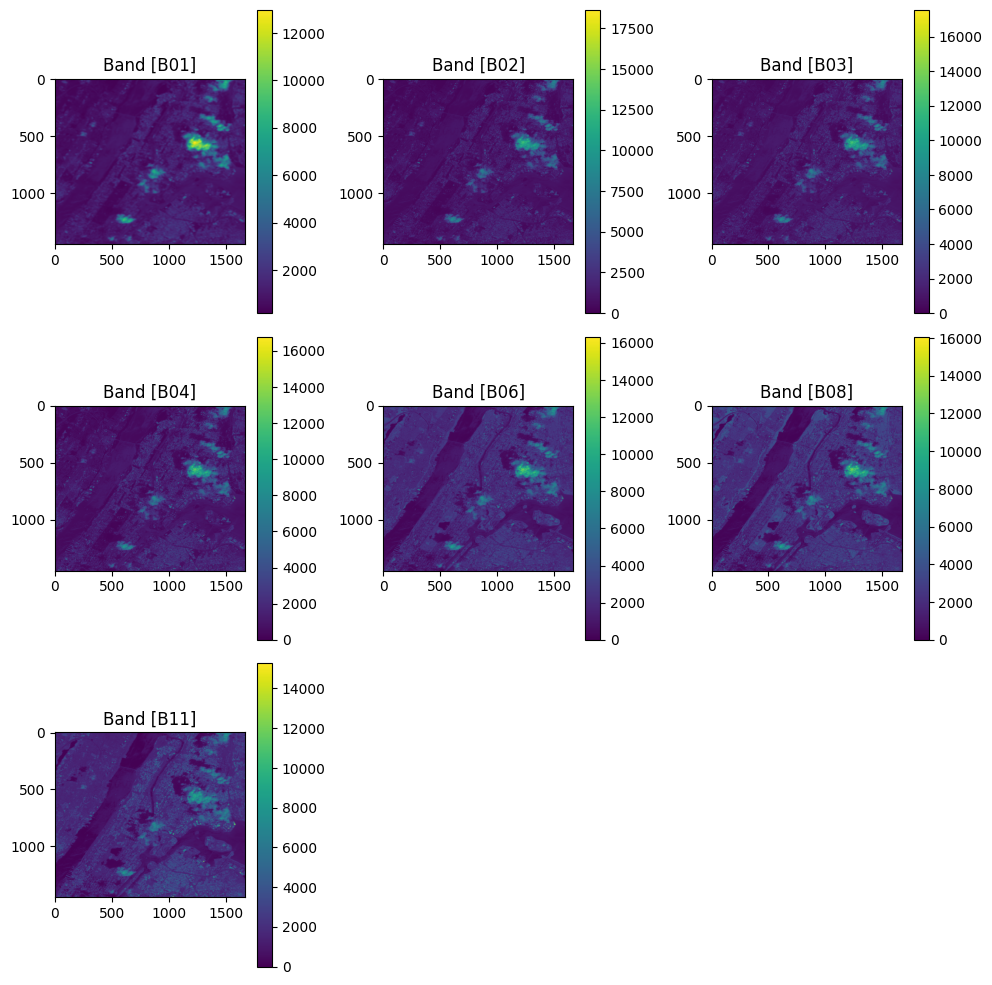

In [6]:
# Reads and plots four bands (B04, B08, B06, B01) from the GeoTIFF file.

# Open the GeoTIFF file
tiff_path_sentinel = "S2_sample_full_bands.tiff"
tiff_path_landsat = "Landsat_LST.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path_sentinel) as src1:
    band1 = src1.read(1)  # Band [B01]
    band2 = src1.read(2)  # Band [B02]
    band3 = src1.read(3)  # Band [B03]
    band4 = src1.read(4)  # Band [B04]
    band5 = src1.read(5)  # Band [B06]
    band6 = src1.read(6)  # Band [B08]
    band7 = src1.read(7)  # Band [B11]

with rasterio.open(tiff_path_landsat) as src2:
    band8 = src2.read() # LST


# Plot the bands in a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Plot Band [B01]
im1 = axes[0].imshow(band1, cmap='viridis')
axes[0].set_title('Band [B01]')
fig.colorbar(im1, ax=axes[0])

# Plot Band [B02]
im2 = axes[1].imshow(band2, cmap='viridis')
axes[1].set_title('Band [B02]')
fig.colorbar(im2, ax=axes[1])

# Plot Band [B03]
im3 = axes[2].imshow(band3, cmap='viridis')
axes[2].set_title('Band [B03]')
fig.colorbar(im3, ax=axes[2])

# Plot Band [B04]
im4 = axes[3].imshow(band4, cmap='viridis')
axes[3].set_title('Band [B04]')
fig.colorbar(im4, ax=axes[3])

# Plot Band [B06]
im5 = axes[4].imshow(band5, cmap='viridis')
axes[4].set_title('Band [B06]')
fig.colorbar(im5, ax=axes[4])

# Plot Band [B08]
im6 = axes[5].imshow(band6, cmap='viridis')
axes[5].set_title('Band [B08]')
fig.colorbar(im6, ax=axes[5])

# Plot Band [B11]
im7 = axes[6].imshow(band7, cmap='viridis')
axes[6].set_title('Band [B11]')
fig.colorbar(im7, ax=axes[6])

# im8 = axes[7].imshow(band8, cmap='viridis')
# axes[7].set_title('Band [LST]')
# fig.colorbar(im8, ax=axes[7])

# Hide unused subplots
for i in range(7, 9):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

<h4><strong>Tip 3</strong></h4>

Instead of a single point data extraction, participants might explore the approach of creating a focal buffer around the locations (e.g., 50 m, 100 m, 150 m etc). For example, if the specified distance was 50 m and the specified band was “Band 2”, then the value of the output pixels from this analysis would reflect the average values in band 2 within 50 meters of the specific location. This approach might help reduction in error associated with spatial autocorrelation. In this demonstration notebook, we are extracting the band data for each of the locations without creating a buffer zone.




### Extracting Band Values from the GeoTIFF Image


In [7]:
# Extracts satellite band values from a GeoTIFF based on coordinates from a CSV file and returns them in a DataFrame.

def map_satellite_data(tiff_path, csv_path):

    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Read the CSV file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # Convert lat/long to the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)

    # Create a transformer object
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    # Initialize lists to store band values
    B01_values = []
    B02_values = []
    B03_values = []
    B04_values = []
    B06_values = []
    B08_values = []
    B11_values = []

    # Iterate over the latitudes and longitudes, and extract the corresponding band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):

        B01_values.append(data.sel(x=lon, y=lat, band=1, method="nearest").values)
        B02_values.append(data.sel(x=lon, y=lat, band=2, method="nearest").values)
        B03_values.append(data.sel(x=lon, y=lat, band=3, method="nearest").values)
        B04_values.append(data.sel(x=lon, y=lat, band=4, method="nearest").values)
        B06_values.append(data.sel(x=lon, y=lat, band=5, method="nearest").values)
        B08_values.append(data.sel(x=lon, y=lat, band=6, method="nearest").values)
        B11_values.append(data.sel(x=lon, y=lat, band=7, method="nearest").values)

    # Create a DataFrame to store the band values
    df = pd.DataFrame({
        'B01': B01_values,
        'B02': B02_values,
        'B03': B03_values,
        'B04': B04_values,
        'B06': B06_values,
        'B08': B08_values,
        'B11': B11_values
    })

    return df


In [8]:
# Mapping satellite data with training data.
final_data = map_satellite_data('S2_sample_full_bands.tiff', 'Training_data_uhi_index_UHI2025-v2.csv')

Mapping values: 100%|██████████| 11229/11229 [01:49<00:00, 102.65it/s]


In [9]:
final_data.head()

,B01,B02,B03,B04,B06,B08,B11
0,846.0,1042.0,1036.0,1036.0,1502.0,1906.0,1487.0
1,846.0,1042.0,1036.0,1036.0,1502.0,1906.0,1487.0
2,846.0,583.0,818.0,709.0,1668.0,2190.0,1465.0
3,846.0,581.0,733.0,657.0,1668.0,2182.0,1465.0
4,846.0,655.0,744.0,745.0,1728.0,2112.0,1544.0


In [ ]:
# Calculate NDVI, NDBI, EVI, NDWI, FVC, E

# Calculate NDVI (Normalized Difference Vegetation Index) and handle division by zero by replacing infinities with NaN.
# See the Sentinel-2 sample notebook for more information about the NDVI index
final_data['NDVI'] = (final_data['B08'] - final_data['B04']) / (final_data['B08'] + final_data['B04'])
final_data['NDVI'] = final_data['NDVI'].replace([np.inf, -np.inf], np.nan)

# NDBI (Normalized Difference Built-up Index)
final_data['NDBI'] = (final_data['B11'] - final_data['B08']) / (final_data['B11'] + final_data['B08'])
final_data['NDBI'] = final_data['NDBI'].replace([np.inf, -np.inf], np.nan)

# Enhanced NDVI (EVI) - Enhanced Vegetation Index
L = 1  # Canopy background adjustment factor
C1 = 6  # Coefficient for the aerosol resistance term
C2 = 7.5  # Coefficient for the aerosol resistance term
G = 2.5  # Gain factor

final_data['EVI'] = G * (final_data['B08'] - final_data['B04']) / \
                    (final_data['B08'] + C1 * final_data['B04'] - C2 * final_data['B02'] + L)
final_data['EVI'] = final_data['EVI'].replace([np.inf, -np.inf], np.nan)

# NDWI (Normalized Difference Water Index)
final_data['NDWI'] = (final_data['B03'] - final_data['B08']) / (final_data['B03'] + final_data['B08'])
final_data['NDWI'] = final_data['NDWI'].replace([np.inf, -np.inf], np.nan)

# Define NDVI thresholds for FVC calculation
# NDVI_min = 0.2  # Typical value for bare soil
# NDVI_max = 0.5  # Typical value for dense vegetation
NDVI_min = min(final_data['NDVI'])
NDVI_max = max(final_data['NDVI'])

# Calculate Fractional Vegetation Cover (FVC)
final_data['FVC'] = ((final_data['NDVI'] - NDVI_min) / (NDVI_max - NDVI_min)) ** 2
final_data['FVC'] = final_data['FVC'].clip(0, 1)  # Ensure FVC is between 0 and 1

# Calculate Emissivity (E)
final_data['E'] = 0.97 + 0.003 * final_data['FVC']

# Replace invalid values (e.g., infinities) with NaN
final_data['E'] = final_data['E'].replace([np.inf, -np.inf], np.nan)

In [56]:
landsat_data = map_satellite_data('Landsat_LST.tiff', 'Training_data_uhi_index_UHI2025-v2.csv')

Mapping values: 100%|██████████| 11229/11229 [01:59<00:00, 93.79it/s] 


In [57]:
landsat_data.head()

,B01,B02,B03,B04,B06,B08,B11
0,38.393941100000006,38.393941100000006,38.393941100000006,38.393941100000006,38.393941100000006,38.393941100000006,38.393941100000006
1,38.393941100000006,38.393941100000006,38.393941100000006,38.393941100000006,38.393941100000006,38.393941100000006,38.393941100000006
2,37.78553354000002,37.78553354000002,37.78553354000002,37.78553354000002,37.78553354000002,37.78553354000002,37.78553354000002
3,37.78553354000002,37.78553354000002,37.78553354000002,37.78553354000002,37.78553354000002,37.78553354000002,37.78553354000002
4,37.35828104000001,37.35828104000001,37.35828104000001,37.35828104000001,37.35828104000001,37.35828104000001,37.35828104000001


### Joining the predictor variables and response variables
Now that we have extracted our predictor variables, we need to join them onto the response variable . We use the function <i><b>combine_two_datasets</b></i> to combine the predictor variables and response variables.The <i><b>concat</b></i> function from pandas comes in handy here.

In [20]:
# Combine two datasets vertically (along columns) using pandas concat function.
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined
    dataset2 - Dataset 2 to be combined
    '''

    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [21]:
# Combining ground data and final data into a single dataset.
uhi_data = combine_two_datasets(ground_df,final_data)
uhi_data.head()

,Longitude,Latitude,datetime,UHI Index,B01,B02,B03,B04,B06,B08,B11,NDVI,NDBI,EVI,NDWI,FVC,E
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,846.0,1042.0,1036.0,1036.0,1502.0,1906.0,1487.0,0.295717,-0.123490,7.061688,-0.295717,0.283900,0.970852
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,846.0,1042.0,1036.0,1036.0,1502.0,1906.0,1487.0,0.295717,-0.123490,7.061688,-0.295717,0.283900,0.970852
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,846.0,583.0,818.0,709.0,1668.0,2190.0,1465.0,0.510866,-0.198358,1.786490,-0.456117,0.492921,0.971479
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,846.0,581.0,733.0,657.0,1668.0,2182.0,1465.0,0.537161,-0.196600,2.157001,-0.497084,0.522397,0.971567
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,846.0,655.0,744.0,745.0,1728.0,2112.0,1544.0,0.478474,-0.155361,2.045795,-0.478992,0.457788,0.971373


### Convolutional kernel

In [ ]:
import rasterio
import numpy as np
from scipy.ndimage import convolve

kernel = np.array([[1, 2, 1],
                  [2, 4, 2],
                  [1, 2, 1]]) / 16.0

# Open the TIFF image
with rasterio.open('S2_sample_full_bands.tiff') as src:
    # Read all bands
    image = src.read()
    # Initialize an array to store convolved bands
    convolved_image = np.empty_like(image)
    # Apply convolution to each band
    for i in range(image.shape[0]):
        convolved_image[i] = convolve(image[i], kernel)

In [ ]:
import pandas as pd
import rasterio
from pyproj import Transformer

# Load training points
train_points = pd.read_csv('Training_data_uhi_index_UHI2025-v2.csv')

# Initialize transformer for coordinate conversion
transformer = Transformer.from_crs("epsg:4326", src.crs, always_xy=True)

# Extract convolved values at training points
features = []
for idx, row in train_points.iterrows():
    lon, lat = row['Longitude'], row['Latitude']
    x, y = transformer.transform(lon, lat)
    row_features = []
    for i in range(convolved_image.shape[0]):
        band = convolved_image[i]
        # Convert coordinates to row, col
        row, col = src.index(x, y)
        row_features.append(band[row, col])
    features.append(row_features)

# Convert to DataFrame
features_df = pd.DataFrame(features, columns=[f'Band_{i+1}' for i in range(convolved_image.shape[0])])


In [ ]:
# Rename bands
band_mapping = {
    'Band_1': 'B01',
    'Band_2': 'B02',
    'Band_3': 'B03',
    'Band_4': 'B04',
    'Band_5': 'B06',
    'Band_6': 'B08',
    'Band_7': 'B11'
}
features_df.rename(columns=band_mapping, inplace=True)

# Compute NDVI (Normalized Difference Vegetation Index)
features_df['convolved_NDVI'] = (features_df['B08'] - features_df['B04']) / (features_df['B08'] + features_df['B04'])
features_df['convolved_NDVI'] = features_df['convolved_NDVI'].replace([np.inf, -np.inf], np.nan)

# Compute NDWI (Normalized Difference Water Index)
features_df['convolved_NDWI'] = (features_df['B03'] - features_df['B08']) / (features_df['B03'] + features_df['B08'])
features_df['convolved_NDWI'] = features_df['convolved_NDWI'].replace([np.inf, -np.inf], np.nan)

In [ ]:
features_df.head()

,B01,B02,B03,B04,B06,B08,B11,convolved_NDVI,convolved_NDWI
0,846.0,858.0625,971.9375,950.9375,1536.3750,1749.6875,1453.0000,0.295765,-0.285767
1,846.0,858.0625,971.9375,950.9375,1536.3750,1749.6875,1453.0000,0.295765,-0.285767
2,846.0,670.5625,811.7500,745.9375,1619.3750,2005.2500,1442.0000,0.457734,-0.423678
3,846.0,622.7500,756.6875,696.1875,1570.4375,1898.3750,1439.5625,0.463349,-0.430004
4,846.0,656.5625,785.8750,773.5625,1674.3125,1935.0000,1547.6875,0.428802,-0.422337


In [ ]:
uhi_data["convolved_NDVI"] = features_df["convolved_NDVI"]
uhi_data["convolved_NDWI"] = features_df["convolved_NDWI"]

In [ ]:
uhi_data.head()

,Longitude,Latitude,datetime,UHI Index,B01,B02,B03,B04,B06,B08,B11,NDVI,NDBI,EVI,NDWI,FVC,E,convolved_NDVI,convolved_NDWI
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,846.0,1042.0,1036.0,1036.0,1502.0,1906.0,1487.0,0.295717,-0.123490,7.061688,-0.295717,0.283900,0.970852,0.295765,-0.285767
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,846.0,1042.0,1036.0,1036.0,1502.0,1906.0,1487.0,0.295717,-0.123490,7.061688,-0.295717,0.283900,0.970852,0.295765,-0.285767
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,846.0,583.0,818.0,709.0,1668.0,2190.0,1465.0,0.510866,-0.198358,1.786490,-0.456117,0.492921,0.971479,0.457734,-0.423678
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,846.0,581.0,733.0,657.0,1668.0,2182.0,1465.0,0.537161,-0.196600,2.157001,-0.497084,0.522397,0.971567,0.463349,-0.430004
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,846.0,655.0,744.0,745.0,1728.0,2112.0,1544.0,0.478474,-0.155361,2.045795,-0.478992,0.457788,0.971373,0.428802,-0.422337


### Removing duplicates
Identical or duplicate entries are removed based on specific columns, in our case [ 'B01','B04','B06','B08','NDVI']. This ensures that the dataset is not biased or skewed by repetitive data, allowing the model to train on unique, relevant observations.

In [ ]:
import numpy as np

def array_to_tuple(x):
    if isinstance(x, np.ndarray):
        if x.ndim == 0:
            # 0D array → return its scalar value
            return x.item()
        else:
            # e.g., 1D array → turn into tuple
            return tuple(x)
    return x

for col_name in uhi_data.columns:
    uhi_data[col_name] = uhi_data[col_name].apply(array_to_tuple)

In [25]:
# Remove duplicate rows from the DataFrame based on specified columns and keep the first occurrence
columns_to_check = uhi_data.columns
for col in columns_to_check:
    # Check if the value is a numpy array and has more than one dimension
    uhi_data[col] = uhi_data[col].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x)

# Now remove duplicates
uhi_data = uhi_data.drop_duplicates(subset=columns_to_check, keep='first')
uhi_data.head()


,Longitude,Latitude,datetime,UHI Index,B01,B02,B03,B04,B06,B08,B11,NDVI,NDBI,EVI,NDWI,FVC,E,convolved_NDVI,convolved_NDWI
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,846.0,1042.0,1036.0,1036.0,1502.0,1906.0,1487.0,0.295717,-0.123490,7.061688,-0.295717,0.283900,0.970852,0.295765,-0.285767
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,846.0,1042.0,1036.0,1036.0,1502.0,1906.0,1487.0,0.295717,-0.123490,7.061688,-0.295717,0.283900,0.970852,0.295765,-0.285767
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,846.0,583.0,818.0,709.0,1668.0,2190.0,1465.0,0.510866,-0.198358,1.786490,-0.456117,0.492921,0.971479,0.457734,-0.423678
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,846.0,581.0,733.0,657.0,1668.0,2182.0,1465.0,0.537161,-0.196600,2.157001,-0.497084,0.522397,0.971567,0.463349,-0.430004
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,846.0,655.0,744.0,745.0,1728.0,2112.0,1544.0,0.478474,-0.155361,2.045795,-0.478992,0.457788,0.971373,0.428802,-0.422337


In [26]:
# Resetting the index of the dataset
uhi_data=uhi_data.reset_index(drop=True)

## Model Building

<p align="justify"> Now let us select the columns required for our model building exercise. We will consider only Band B01, Band B06 and NDVI from the Sentinel-2 data as our predictor variables. It does not make sense to use latitude and longitude as predictor variables, as they do not have any direct impact on predicting the UHI index.</p>


In [27]:
# Retaining only the columns for B01, B06, NDVI, and UHI Index in the dataset.
uhi_data = uhi_data[['B01', 'B06', 'B11', 'NDVI', 'NDWI', 'UHI Index', 'convolved_NDVI', 'convolved_NDWI']]

# uhi_data = uhi_data[['B01', 'B02', 'B03',
#        'B04', 'B06', 'B08', 'B11', 'NDVI', 'NDBI', 'EVI', 'NDWI', 'FVC', 'E', 'UHI Index']]



### Train and Test Split

<p align="justify">Autogluon automatically handles data splitting by allocating a portion of the training data for validation. This eliminates the need for manual train-test splitting, optimizing model selection and hyperparameter tuning.</p>

### Feature Scaling

<p align="justify"> Autogluon automates data preprocessing, including handling missing values, categorical encoding, and feature scaling when necessary. Unlike traditional machine learning workflows that require manual scaling, Autogluon selects appropriate transformations based on the model type</p>

<h4><strong>Tip 4</strong></h4>
<p align="justify">There are many data preprocessing methods available, which might help to improve the model performance. Participants should explore various suitable preprocessing methods as well as different machine learning algorithms to build a robust model.</p>

### Model Training

In [28]:
!python -m pip install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 19.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. 

In [ ]:
# Depend on the numpy version in your machine, autogluon may not work as expected
!pip uninstall numpy -y; pip install numpy  

In [ ]:
# from autogluon.core.metrics import make_scorer
# from sklearn.metrics import r2_score

# # Create a custom metric that AutoGluon understands
# r2_metric = make_scorer(
#     name='r2',
#     score_func=r2_score,        # function that takes (y_true, y_pred)
#     optimum=1.0,
#     greater_is_better=True
# )

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor


# Add ag_args_fit={'num_gpus': 1} to fit() to use GPU
predictor = TabularPredictor(label='UHI Index', eval_metric="r2").fit(uhi_data, presets='best_quality', time_limit = 3600)

No path specified. Models will be saved in: "AutogluonModels/ag-20250320_005645"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       9.86 GB / 12.67 GB (77.8%)
Disk Space Avail:   0.28 GB / 15.00 GB (1.9%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This

(_ray_fit pid=24421) [1000]	valid_set's l2: 0.000178382	valid_set's r2: 0.29962
(_ray_fit pid=24421) [3000]	valid_set's l2: 0.000157369	valid_set's r2: 0.382122 [repeated 4x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(_ray_fit pid=24421) [5000]	valid_set's l2: 0.000147528	valid_set's r2: 0.420761 [repeated 4x across cluster]
(_ray_fit pid=24421) [7000]	valid_set's l2: 0.000141482	valid_set's r2: 0.4445 [repeated 4x across cluster]
(_ray_fit pid=24421) [9000]	valid_set's l2: 0.000137914	valid_set's r2: 0.45851 [repeated 4x across cluster]
(_ray_fit pid=24421) [10000]	valid_set's l2: 0.000136475	valid_set's r2: 0.46416 [repeated 2x across cluster]
(_ray_fit pid=24734) [1000]	valid_set's l2: 0.000168854	valid_set's r2: 0.327317 [repeated 2x across cluster]
(_ray_fit pid=24726) [3000]	valid_set's l2: 0.0001

(_dystack pid=24248) 	0.4641	 = Validation score   (r2)
(_dystack pid=24248) 	226.12s	 = Training   runtime
(_dystack pid=24248) 	45.63s	 = Validation runtime
(_dystack pid=24248) Fitting model: LightGBM_BAG_L1 ... Training model for up to 354.78s of the 652.86s of remaining time.
(_dystack pid=24248) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.06%)


(_ray_fit pid=25675) [1000]	valid_set's l2: 0.000121383	valid_set's r2: 0.523416 [repeated 2x across cluster]
(_ray_fit pid=25675) [2000]	valid_set's l2: 0.000109124	valid_set's r2: 0.571545 [repeated 2x across cluster]
(_ray_fit pid=25675) [4000]	valid_set's l2: 0.000103347	valid_set's r2: 0.594229 [repeated 4x across cluster]
(_ray_fit pid=25675) [6000]	valid_set's l2: 0.000102251	valid_set's r2: 0.598534 [repeated 4x across cluster]
(_ray_fit pid=25675) [7000]	valid_set's l2: 0.000102036	valid_set's r2: 0.599378 [repeated 2x across cluster]
(_ray_fit pid=25675) [8000]	valid_set's l2: 0.000101962	valid_set's r2: 0.599667 [repeated 2x across cluster]
(_ray_fit pid=25675) [10000]	valid_set's l2: 0.000101842	valid_set's r2: 0.600139 [repeated 2x across cluster]
(_ray_fit pid=25962) [1000]	valid_set's l2: 0.000124374	valid_set's r2: 0.540676
(_ray_fit pid=25962) [2000]	valid_set's l2: 0.000113122	valid_set's r2: 0.582231
(_ray_fit pid=25962) [3000]	valid_set's l2: 0.00010839	valid_set's 

(_dystack pid=24248) 	0.5855	 = Validation score   (r2)
(_dystack pid=24248) 	227.29s	 = Training   runtime
(_dystack pid=24248) 	31.97s	 = Validation runtime
(_dystack pid=24248) Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 118.80s of the 416.88s of remaining time.
(_dystack pid=24248) 	0.62	 = Validation score   (r2)
(_dystack pid=24248) 	26.06s	 = Training   runtime
(_dystack pid=24248) 	0.85s	 = Validation runtime
(_dystack pid=24248) Fitting model: CatBoost_BAG_L1 ... Training model for up to 90.19s of the 388.27s of remaining time.
(_dystack pid=24248) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=0.07%)
(_dystack pid=24248) 	Warning: Exception caused CatBoost_BAG_L1 to fail during training (ImportError)... Skipping this model.
(_dystack pid=24248) 		ray::_ray_fit() (pid=27054, ip=172.28.0.12)
(_dystack pid=24248)   File "/usr/local/lib/python3.11/dist-packages/catboost/__init__.

In [34]:
results = predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val eval_metric  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3   0.833247          r2     138.663036  2404.194365                0.001668           0.421412            3       True         20
1   NeuralNetFastAI_BAG_L2   0.831022          r2     136.080721  1845.992711                0.338844         147.743725            2       True         16
2          LightGBM_BAG_L2   0.826044          r2     135.883909  1742.182125                0.142032          43.933139            2       True         13
3    NeuralNetTorch_BAG_L2   0.824479          r2     136.207902  2052.877052                0.466025         354.628066            2       True         18
4     ExtraTreesMSE_BAG_L2   0.824000          r2     136.506841  1713.877530                0.764964          15.628544            2       True         15
5 

### Model Evaluation

<p align="justify">Now that we have trained our model, the next step is to evaluate its performance. For evaluation, we will use the R² score, a common metric for regression models that measures how well the model explains the variance in the response variable (UHI index). Scikit-learn provides many other metrics that can be used for evaluation, and you can also write custom code for more specific evaluation needs.</p>


In [ ]:
predictor.evaluate(uhi_data, silent=True)

In [ ]:
predictor.feature_importance(uhi_data)

Computing feature importance via permutation shuffling for 7 features using 5000 rows with 5 shuffle sets...
	1476.39s	= Expected runtime (295.28s per shuffle set)
	1371.02s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
B01,1.148922,0.018764,8.534877e-09,5,1.187558,1.110286
B11,0.789832,0.016117,2.079287e-08,5,0.823017,0.756647
B06,0.737627,0.018051,4.300225e-08,5,0.774794,0.700460
convolved_NDVI,0.043008,0.001680,2.790334e-07,5,0.046467,0.039548
convolved_NDWI,0.023265,0.001111,6.230400e-07,5,0.025553,0.020976
NDWI,0.022083,0.001473,2.360766e-06,5,0.025115,0.019050
NDVI,0.020317,0.001102,1.032807e-06,5,0.022586,0.018049


## Submission

Once you are satisfied with your model, you can proceed to make a submission. To do this, you will need to use your model to predict the Urban Heat Island (UHI) index for a set of test coordinates provided in the <b>"Submission_template.csv"</b> file and upload the results to the challenge platform.

In [ ]:
#Reading the coordinates for the submission
test_file = pd.read_csv('Submission_template_UHI2025-v2.csv')
test_file.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,NaN
1,-73.971928,40.788875,NaN
2,-73.967080,40.789080,NaN
3,-73.972550,40.789082,NaN
4,-73.969697,40.787953,NaN


In [ ]:
# Mapping satellite data for submission.
val_data = map_satellite_data('S2_sample_full_bands.tiff', 'Submission_template_UHI2025-v2.csv')

Mapping values: 100%|██████████| 1040/1040 [00:11<00:00, 87.95it/s]


### Generating Indices

In [ ]:
# Calculate NDVI (Normalized Difference Vegetation Index) and handle division by zero by replacing infinities with NaN.
val_data['NDVI'] = (val_data['B08'] - val_data['B04']) / (val_data['B08'] + val_data['B04'])
val_data['NDVI'] = val_data['NDVI'].replace([np.inf, -np.inf], np.nan)  # Replace infinities with NaN

# NDBI (Normalized Difference Built-up Index)
val_data['NDBI'] = (val_data['B11'] - val_data['B08']) / (val_data['B11'] + val_data['B08'])
val_data['NDBI'] = val_data['NDBI'].replace([np.inf, -np.inf], np.nan)

# Enhanced NDVI (EVI) - Enhanced Vegetation Index
L = 1  # Canopy background adjustment factor
C1 = 6  # Coefficient for the aerosol resistance term
C2 = 7.5  # Coefficient for the aerosol resistance term
G = 2.5  # Gain factor

val_data['EVI'] = G * (val_data['B08'] - val_data['B04']) / \
                    (val_data['B08'] + C1 * val_data['B04'] - C2 * val_data['B02'] + L)
val_data['EVI'] = val_data['EVI'].replace([np.inf, -np.inf], np.nan)

# NDWI (Normalized Difference Water Index)
val_data['NDWI'] = (val_data['B03'] - val_data['B08']) / (val_data['B03'] + val_data['B08'])
val_data['NDWI'] = val_data['NDWI'].replace([np.inf, -np.inf], np.nan)

# Define NDVI thresholds for FVC calculation
# NDVI_min = 0.2  # Typical value for bare soil
# NDVI_max = 0.5  # Typical value for dense vegetation
NDVI_min = min(val_data['NDVI'])
NDVI_max = max(val_data['NDVI'])

# Calculate Fractional Vegetation Cover (FVC)
val_data['FVC'] = ((val_data['NDVI'] - NDVI_min) / (NDVI_max - NDVI_min)) ** 2
val_data['FVC'] = val_data['FVC'].clip(0, 1)  # Ensure FVC is between 0 and 1

# Calculate Emissivity (E)
val_data['E'] = 0.97 + 0.003 * val_data['FVC']

# Replace invalid values (e.g., infinities) with NaN
val_data['E'] = val_data['E'].replace([np.inf, -np.inf], np.nan)

In [ ]:
val_data.head()

,B01,B02,B03,B04,B06,B08,B11,NDVI,NDBI,EVI,NDWI,FVC,E
0,811.0,459.0,617.0,432.0,2089.0,2502.0,1474.0,0.705521,-0.258551,3.131619,-0.604360,0.734555,0.972204
1,1208.0,562.0,731.0,647.0,2076.0,2906.0,1751.0,0.635801,-0.248014,2.194056,-0.598020,0.622211,0.971867
2,899.0,955.0,1052.0,1188.0,995.0,1246.0,1101.0,0.023829,-0.061781,0.119588,-0.084421,0.035975,0.970108
3,1193.0,1132.0,1364.0,1512.0,1939.0,1774.0,2521.0,0.079732,0.173923,0.277896,-0.130656,0.059732,0.970179
4,1097.0,1506.0,1642.0,1688.0,2204.0,2834.0,2248.0,0.253428,-0.115309,1.717626,-0.266309,0.171771,0.970515


### Convolutional kernel

In [ ]:
import rasterio
import numpy as np
from scipy.ndimage import convolve

kernel = np.array([[1, 2, 1],
                  [2, 4, 2],
                  [1, 2, 1]]) / 16.0

# Open the TIFF image
with rasterio.open('S2_sample_full_bands.tiff') as src:
    # Read all bands
    image = src.read()
    # Initialize an array to store convolved bands
    convolved_image = np.empty_like(image)
    # Apply convolution to each band
    for i in range(image.shape[0]):
        convolved_image[i] = convolve(image[i], kernel)

In [ ]:
import pandas as pd
import rasterio
from pyproj import Transformer

# Load training points
train_points = pd.read_csv('Submission_template_UHI2025-v2.csv')

# Initialize transformer for coordinate conversion
transformer = Transformer.from_crs("epsg:4326", src.crs, always_xy=True)

# Extract convolved values at training points
features = []
for idx, row in train_points.iterrows():
    lon, lat = row['Longitude'], row['Latitude']
    x, y = transformer.transform(lon, lat)
    row_features = []
    for i in range(convolved_image.shape[0]):
        band = convolved_image[i]
        # Convert coordinates to row, col
        row, col = src.index(x, y)
        row_features.append(band[row, col])
    features.append(row_features)

# Convert to DataFrame
features_df = pd.DataFrame(features, columns=[f'Band_{i+1}' for i in range(convolved_image.shape[0])])


In [ ]:
# Rename bands
band_mapping = {
    'Band_1': 'B01',
    'Band_2': 'B02',
    'Band_3': 'B03',
    'Band_4': 'B04',
    'Band_5': 'B06',
    'Band_6': 'B08',
    'Band_7': 'B11'
}
features_df.rename(columns=band_mapping, inplace=True)

# Compute NDVI (Normalized Difference Vegetation Index)
features_df['convolved_NDVI'] = (features_df['B08'] - features_df['B04']) / (features_df['B08'] + features_df['B04'])
features_df['convolved_NDVI'] = features_df['convolved_NDVI'].replace([np.inf, -np.inf], np.nan)

# Compute NDWI (Normalized Difference Water Index)
features_df['convolved_NDWI'] = (features_df['B03'] - features_df['B08']) / (features_df['B03'] + features_df['B08'])
features_df['convolved_NDWI'] = features_df['convolved_NDWI'].replace([np.inf, -np.inf], np.nan)

In [ ]:
features_df.head()

,B01,B02,B03,B04,B06,B08,B11,convolved_NDVI,convolved_NDWI
0,811.0000,455.1875,617.1250,462.1875,2022.0625,2427.750,1479.2500,0.680140,-0.594647
1,1106.4375,577.9375,732.5000,636.7500,2067.1250,2765.125,1685.0625,0.625648,-0.581144
2,899.0000,770.8750,859.3750,895.1875,987.4375,1111.000,1117.6875,0.107573,-0.127704
3,1262.0000,1226.8750,1399.5000,1627.6875,2056.0625,1892.500,2570.3750,0.075227,-0.149757
4,1143.7500,1659.1875,1803.5625,1824.6875,2358.3125,2876.875,2414.0625,0.223795,-0.229319


In [ ]:
val_data["convolved_NDVI"] = features_df["convolved_NDVI"]
val_data["convolved_NDWI"] = features_df["convolved_NDWI"]

In [ ]:
val_data.head()

,B01,B02,B03,B04,B06,B08,B11,NDVI,NDBI,EVI,NDWI,FVC,E,convolved_NDVI,convolved_NDWI
0,811.0,459.0,617.0,432.0,2089.0,2502.0,1474.0,0.705521,-0.258551,3.131619,-0.604360,0.734555,0.972204,0.680140,-0.594647
1,1208.0,562.0,731.0,647.0,2076.0,2906.0,1751.0,0.635801,-0.248014,2.194056,-0.598020,0.622211,0.971867,0.625648,-0.581144
2,899.0,955.0,1052.0,1188.0,995.0,1246.0,1101.0,0.023829,-0.061781,0.119588,-0.084421,0.035975,0.970108,0.107573,-0.127704
3,1193.0,1132.0,1364.0,1512.0,1939.0,1774.0,2521.0,0.079732,0.173923,0.277896,-0.130656,0.059732,0.970179,0.075227,-0.149757
4,1097.0,1506.0,1642.0,1688.0,2204.0,2834.0,2248.0,0.253428,-0.115309,1.717626,-0.266309,0.171771,0.970515,0.223795,-0.229319


### Predictions

In [ ]:
# Extracting specific columns (B01, B06, and NDVI) from the validation dataset
submission_val_data=val_data.loc[:,['B01', 'B06', 'B11', 'NDVI', 'NDWI', "convolved_NDVI", "convolved_NDWI"]]
submission_val_data.head()

,B01,B06,B11,NDVI,NDWI,convolved_NDVI,convolved_NDWI
0,811.0,2089.0,1474.0,0.705521,-0.604360,0.680140,-0.594647
1,1208.0,2076.0,1751.0,0.635801,-0.598020,0.625648,-0.581144
2,899.0,995.0,1101.0,0.023829,-0.084421,0.107573,-0.127704
3,1193.0,1939.0,2521.0,0.079732,-0.130656,0.075227,-0.149757
4,1097.0,2204.0,2248.0,0.253428,-0.266309,0.223795,-0.229319


In [ ]:
#Making predictions
# final_predictions = model.predict(transformed_submission_data)
final_predictions = predictor.predict(submission_val_data)
final_prediction_series = pd.Series(final_predictions)

### Exporting CSV

In [ ]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'Longitude':test_file['Longitude'].values, 'Latitude':test_file['Latitude'].values, 'UHI Index':final_prediction_series.values})

In [ ]:
#Displaying the sample submission dataframe
submission_df.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,0.964034
1,-73.971928,40.788875,0.964119
2,-73.967080,40.789080,0.977178
3,-73.972550,40.789082,0.961983
4,-73.969697,40.787953,0.963005


In [ ]:
#Dumping the predictions into a csv file.
submission_df.to_csv("submission.csv",index = False)

### Upload submission file on platform

Upload the submission.csv on the <a href ="https://challenge.ey.com">platform</a> to get score generated on scoreboard.